# Biological Softmax
This notebook covers softmax in the context of biologically plausible neurons.  
Krotov and Hopfield proposed a model of large associative memory that moves closer to being biologically plausible by addressing the many-body synapse issue.  
Here, we implement the idea from Snow and Orchard, a more biological implementation of the softmax function. 

In [82]:
# import libraries
import time
import statistics
import numpy as np
from scipy.integrate import odeint # It is used to numerically solve systems of first-order ordinary differential equations (ODEs)
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation
%matplotlib notebook

The approach is to couple a set of Nh "memory" neurons (with input currents hu) to the Ny feature neurons (with input currents vi)

In [141]:
# setting up the variables
# Nh, memory neurons
# h, input value of the neurons
# tau_s, controls the speed of convergence to equilibrium.
Nh = 3
h = np.array([1.0, 2.0, 3.0])
tau_s = 1.0 

In [142]:
initial_state = np.zeros(1 + Nh + Nh)
t = np.linspace(0, 10, 500) # Array of time points at which to solve

In [143]:
def softmax_dynamics_safe(state, t, h, tau_s, eps=1e-8):
    Nh = len(h)
    b = state[0]       # scalar inhibitory pool
    r = state[1:1+Nh]  # hidden log-scores (vector, one per neuron)
    f = state[1+Nh:]   # firing rates (vector, one per neuron)

    # safety: ensure b non-negative and not tiny for log
    if b < eps:
        b_safe = eps
    else:
        b_safe = b

    # ODEs
    db_dt = (np.sum(np.exp(h)) - b) / tau_s
    dr_dt = (h - np.log(b_safe) - r) / tau_s
    df_dt = (np.exp(r) - f) / tau_s

    return np.concatenate(([db_dt], dr_dt, df_dt))


In [144]:
solution = odeint(softmax_dynamics_safe, initial_state, t, args=(h, tau_s))
f_vals = solution[:, 1+Nh:]
# The last Nh columns, one per neuron, storing the firing rates

In [145]:
print("sum f(T) =", f_vals[-1].sum())  

sum f(T) = 1.0032753204313587


In [146]:
f_vals
# each column is one neuron’s firing rate over time.

array([[0.        , 0.        , 0.        ],
       [0.02044615, 0.02065328, 0.02086318],
       [0.04114128, 0.04197994, 0.04284118],
       ...,
       [0.09044439, 0.24564706, 0.66729543],
       [0.0904373 , 0.24563165, 0.6672617 ],
       [0.09043033, 0.24561649, 0.6672285 ]], shape=(500, 3))

In [147]:
b_vals = solution[:, 0]
r_vals = solution[:, 1:1+Nh]
f_vals = solution[:, 1+Nh:]

<IPython.core.display.Javascript object>

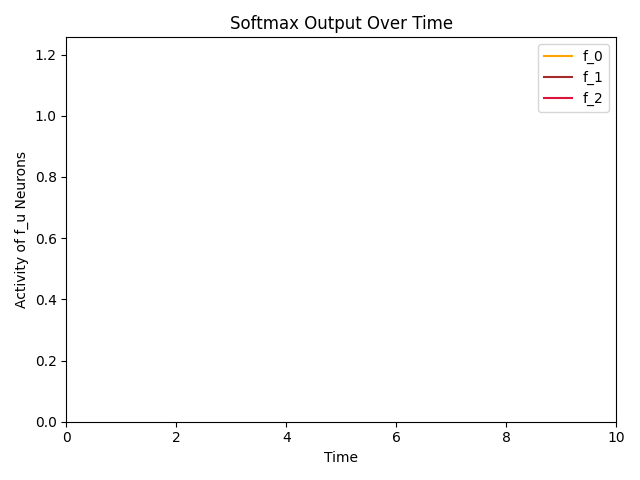

In [148]:
# --- Animation setup ---
fig, ax = plt.subplots()
lines = [ax.plot([], [], label=f'f_{i}')[0] for i in range(Nh)]
colors = ['orange', 'brown', 'crimson']
for line, color in zip(lines, colors):
    line.set_color(color)

ax.set_xlim(0, t[-1])
ax.set_ylim(0, np.max(f_vals) * 1.1)
ax.set_title('Softmax Output Over Time')
ax.set_xlabel('Time')
ax.set_ylabel('Activity of f_u Neurons')
ax.legend()

# Initialize each line
def init():
    for line in lines:
        line.set_data([], [])
    return lines

# Update function for animation
def update(frame):
    for i, line in enumerate(lines):
        line.set_data(t[:frame], f_vals[:frame, i])
    return lines

# Create animation
ani = FuncAnimation(fig, update, frames=len(t), init_func=init,
                    blit=True, interval=30)

plt.tight_layout()
plt.show()

ani.save('softmax_dynamics.gif', writer='pillow', fps=30)
from IPython.display import Image
Image(filename='softmax_dynamics.gif')